<a href="https://colab.research.google.com/github/Ujustwaite/ml1/blob/master/Lab_2_Waite_Garapati_Henderson_Walenciak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 3: Clustering Using New York City Fire Department Data:**


### Team: Aditya Garapati, Chase Henderson, Brian Waite, Carl Walenciak

### Date: 11/19/2019




In [215]:
!pip install category_encoders
!pip install apyori

In [216]:
#Imports Section
import category_encoders as ce
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# General Description:

## Business Understanding:

This is a continuation of the analysis of the Fire Department of New York City (FDNY) data describing fire incidents in support of the New York Fire Incident Reporting System (NYFIRS). Prior to and during our initial data preparation, we identified a number of analytic questions that could be of interest to fire resource planners. This data is collected to support local decision maker tools and is made available to the public as part of open government initiatives in the State of New York. 

New York City uses a series of alarm codes to identify the severity of a fire and the associated response. These alarm codes are described at the following web locations: 

http://www.fdnewyork.com/aa.asp

https://en.wikipedia.org/wiki/New_York_City_Fire_Department#Radio_and_bell_code_signals


In renewing this analysis, we are seeking to determine whether clustering algorithms can help to provide additional insight to the decision makers we have previously described and the problems identified. These include deriving insights about whether there are clusters within the data that help to identify factors contributing to the total incident duration of fire events, regional risk associated with fires, fire types, or other factors that might help to inform decisions related to the allocation of fire resources (personnel, equipment, or station location). 



### Measuring the effectiveness of clustering techniques as applied to this data. 

In Lab 2, we developed classification models that did not leverage a pre-processing step of clustering. These models provide a baseline set of metrics that we can use to determine if clustering provides additional insight and ability to describe trends in the data. By comparing the accuracy, precision, and recall of our classification models before and after the application of clustering, we can make concrete comparisons. 

Beyond these concrete metrics, we can visually explore the outcomes of the clustering process when overlaid on other factors to either reinforce or dispute our previous evaluation. 

### Why does your chosen validation method make sense for this specific dataset and the stakeholders needs? 

By being able to explicitly capture the accuracy, precision, recall and to visualize the impact of a model enhanced by clustering, we can provide stakeholders with a clear, quantifiable statement of the model performance and therefore some sense of how they can rely on the predictions it makes. These metrics will capture both the value and the limitations of the model, specifically given the upsampling required to ensure viability of the model and the associated degredation of precision and increase of recall. The visualization information or the more narrative insights that result from our evaluation of these predictions will ultimately be of more use to the decision makers. 

## Data Understanding: 

### Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?  

A robust description of the data has been previously provided along with an associated Exploratory Data Analysis. That information is available here for reference: https://colab.research.google.com/github/Ujustwaite/ml1/blob/master/Playing_With_Fire.ipynb


### Data Cleaning:

To optimize this analysis, we need to do some additional transformation of the data and some leftover housekeeping from our EDA. This includes:

    Conversion of the presence of the Automatic Extinguisher System to either "not present = 0" or "present = 1".

    Conversion of the presence of a fire dector to either "not present = 0" or "present = 1".

    Conversion of the presence of a standpipe system to "not present = 0" or "present = 1".

    Filling of missing total_incident_duration values with the mean value. Note that this process has been updated to take place after the separation of the Train / Test data in order to not pollute the model with advance knowledge of the Test data set.

    Correction of two incorrect zip code values.

    Dropping of categorical fields that are freely input by the user and are unusable for analysis or are not consistently used in a meaningful sense for this problem.



In [217]:
#Read in the data output from EDA step
final_df = pd.read_pickle('final_df.pkl')

In [218]:
#DATA CLEANING BLOCK

#AES presence update
final_df.loc[final_df['aes_presence_desc'] == '1 - Present', 'aes_presence_desc'] = 1
final_df.loc[final_df['aes_presence_desc'] != 1, 'aes_presence_desc'] = 0

#Smoke Detector presence update
final_df.loc[final_df['detector_presence_desc'] == '1 - Present', 'detector_presence_desc'] = 1
final_df.loc[final_df['detector_presence_desc'] != 1, 'detector_presence_desc'] = 0

#Standpipe presence update
final_df.loc[final_df['standpipe_sys_present_flag'] == '1', 'standpipe_sys_present_flag'] = 1
final_df.loc[final_df['standpipe_sys_present_flag'] != 1, 'standpipe_sys_present_flag'] = 0

#Replacement of missing zip codes
#Identified values using google maps and intersection information
final_df.at[18695, 'zip_code'] = '11103'
final_df.at[18760, 'zip_code'] = '11357'

#Drop the categorical columns determined to be unusable
final_df = final_df.drop(columns = ['fire_spread_desc','floor','story_fire_origin_count'])

#Drop the remaining 19 values that are missing the highest level alarm description
final_df.dropna(inplace = True)

#### Adding an 'hour' feature. 

While we have not previously used the "time" of fire for analysis. After revisiting our EDA, we find that there was a trend in the number of fires occurring during the time of day. This might be useful in additional analysis to help with determining fire severity and the existence of clusters. 

We'll create a new feature that draws the hour (time of day) out of the incident date time for use in our clustering algorithms. 

In [219]:
final_df['hour'] = final_df.incident_date_time.dt.hour

In [220]:
final_df.columns

Index(['action_taken1_desc', 'action_taken2_desc', 'action_taken3_desc',
       'aes_presence_desc', 'borough_desc', 'detector_presence_desc',
       'fire_box', 'highest_level_desc', 'im_incident_key',
       'incident_date_time', 'incident_type_desc',
       'last_unit_cleared_date_time', 'property_use_desc',
       'standpipe_sys_present_flag', 'street_highway',
       'total_incident_duration', 'units_onscene', 'zip_code', 'response_time',
       'LONG', 'LAT', 'nearest_intersection', 'incident_code', 'incident_desc',
       'Distance_To_Nearest_Station', 'DATE', 'PRCP', 'SNOW', 'SNWD',
       'incident_month', 'hour'],
      dtype='object')

## Original Classification Problem from Lab 2: Predicting High-Alarm vs. Low-Alarm Fires


Our original analysis built models to predict whether a fire constitutes a severe, high level incident, or a less-severe fire based on parameters contained in the available data set. While our models performed well, we'll seek to improve on that performance by adding a clustering step. 

#### Additional data preparation

Because the target variable is not currently in the data set, we must construct it with the existing available data set. 

Here we will take the existing feature, `highest_level_desc` that defines the level of alarm raised for each incident in the data set and convert it to a binary value. The values contained in the data set are: 

In [221]:
final_df.highest_level_desc.unique()

array(['11 - First Alarm', '75 - All Hands Working',
       '1 - More than initial alarm, less than Signal 7-5',
       '7 - Signal 7-5', '2 - 2nd alarm', '0 - Initial alarm',
       '22 - Second Alarm', '5 - 5th alarm', '4 - 4th alarm',
       '3 - 3rd alarm', '55 - Fifth Alarm', '33 - Third Alarm',
       '44 - Fourth Alarm'], dtype=object)

As you might expect, the majority of the events occuring throughout the city are low-level fires.

In [222]:
grouped = final_df.groupby(['highest_level_desc'])
grouped.count().im_incident_key

highest_level_desc
0 - Initial alarm                                       19
1 - More than initial alarm, less than Signal 7-5    12963
11 - First Alarm                                     11873
2 - 2nd alarm                                           53
22 - Second Alarm                                       47
3 - 3rd alarm                                           13
33 - Third Alarm                                        11
4 - 4th alarm                                            4
44 - Fourth Alarm                                        5
5 - 5th alarm                                            5
55 - Fifth Alarm                                         5
7 - Signal 7-5                                         701
75 - All Hands Working                                 621
Name: im_incident_key, dtype: int64

This means we have the potential for the data of "in class" vs. "out of class" to be highly imbalanced. We'll address this later in our analysis. For our analysis, we determined based on the definitions of the alarms in the references provided and on our initial EDA, that a severe fire is level 2 including Signal 7 / Signal 75, which are not truly 2 alarm or higher, but help to balance the in class data set. 

In [223]:
#Split the alarm code off the front of the description
new = final_df["highest_level_desc"].str.split(" ", n = 1, expand = True) 
#Convert to integer
new[0] = new[0].astype('int32')
#Map the classifications according to alarm code
desc = {2: 1,22: 1, 3:1,33:1,4:1,44:1,5:1,55:1,0:0,1:0,11:0,7:1,75:1,} 
final_df['FireLevel'] = [desc[item] for item in new[0]] 

Our target variable is now contained in the data frame as `FireLevel`. As we can see, there are 1,467 in class values out of the total 26,322 records. Approximately 5.6 percent. We will monitor and adjust for this imbalance throughout our analysis. 

## Encoding of Categorical Predictors

While we won't use the categorical features in our clustering analysis, since they are essentially clusters on their own, we will want them when we eventually return to evaluating our model's predictive ability, so we'll set them up here. 

In [224]:
#Encode borough description
label = ce.OneHotEncoder(use_cat_names=True)
borough_label = label.fit_transform(final_df[['borough_desc']])

#Encode incident type
label = ce.OneHotEncoder(use_cat_names=True)
incident_type_label = label.fit_transform(final_df[['incident_type_desc']])

#Encode actiontaken 1 label -- the primary action taken by units onscene
label = ce.OneHotEncoder(use_cat_names=True)
action_taken_1_label = label.fit_transform(final_df[['action_taken1_desc']])

#Encode highest level desc for Problem 2
label = ce.OneHotEncoder(use_cat_names=True)
highest_level_label = label.fit_transform(final_df[['highest_level_desc']])

## Drop Columns Not to be Used in Analysis


A number of the columns in the dataframe are now duplicative of the encoded columns or are redundant / not useful. Things like zip_code, street_highway, and nearest_intersection are already captured in lat/long that we'll retain. We have translated Date Time related information into the Total Incident Duration and will not use that here. We also keep the unique incident key 'im_incident_key' for the later association rule analysis. 

In [225]:
#drop the unnecessary columns
model_df = final_df.drop(columns = ['action_taken1_desc', 'action_taken2_desc', 'action_taken3_desc','fire_box', 'highest_level_desc', 'incident_date_time', 'incident_type_desc', 'last_unit_cleared_date_time', 'property_use_desc', 'street_highway', 'zip_code', 'nearest_intersection','incident_code', 'incident_desc', 'DATE'])

In [226]:
#concatenate the encoded columns
model_df = pd.concat([model_df,incident_type_label, action_taken_1_label, borough_label], axis = 1)

In [227]:
#Move the target value to the end of the dataframe and rename as target
model_df['target'] = model_df['FireLevel']
model_df = model_df.drop(columns = 'FireLevel')

Although during the previous assignments, we identified that the `units_onscene` and `total_incident_duration` were essentially representing the same value as our "to be predicted" target variable, for the purposes of our clustering analysis, we'll initially leave them in and see if they help to provide some value to the clustering algorithm. 

In [228]:
#Let's comment out this code for now and see if we can use them to cluster. 
#model_df = model_df.drop(columns = ['total_incident_duration', 'units_onscene'])

## Create Train / Test Split

In order to prepare for the analysis, we will use a shuffled 80/20 Train-Test split with stratification due to the small number of representative samples of the "in class" variables described above. The data is randomly selected for inclusion in either split, with a set seed to enable replication of results, but is stratified to ensure representation in both the train and test sets of the in class records. 

In [229]:
#Problem 1 data
X_train, X_test, y_train, y_test = train_test_split(model_df.iloc[:,0:98], model_df.iloc[:,98], test_size=0.20, random_state=42, shuffle = True, stratify = model_df.iloc[:,97])


### Scaling

Also, to properly evaluate the relative importance of features in some of the models, we create a scaled version of the data. This is particularly useful when comparing the feature importance in the logistic regression and to properly execute the svm. Scales are built on the training data and applied to the test data in order to maintain the same relative importance / values. 

# Modeling and Evaluation

## Cluster Analysis

As described above, we'll attempt to explore our data set with clustering analysis to help better inform our classification model. We can then compare our previous model with our new and improved results to evaluate the difference and value of clustering. 

In [230]:
X_train.columns
cols_to_keep = ['response_time','LONG', 'LAT', 'PRCP','SNOW','SNWD','Distance_To_Nearest_Station','hour', 'total_incident_duration','units_onscene']
X_train2 = X_train[cols_to_keep]

In [231]:
kmeans = KMeans(init='random', # initialization
        n_clusters=4,  # number of clusters
        n_init=7,       # number of different times to run k-means
        n_jobs=-1)

kmeans.fit(X_train2)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=4,
       n_init=7, n_jobs=-1, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=0)

In [232]:
labels = kmeans.labels_

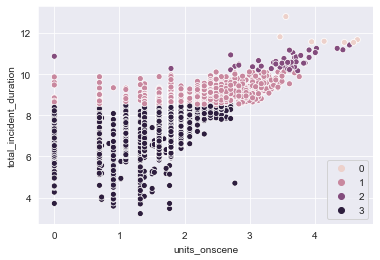

In [233]:
sns.scatterplot(x = np.log(X_train['units_onscene']), y = np.log(X_train['total_incident_duration']), hue = labels)

In [234]:
y_train.unique()

array([0, 1], dtype=int64)

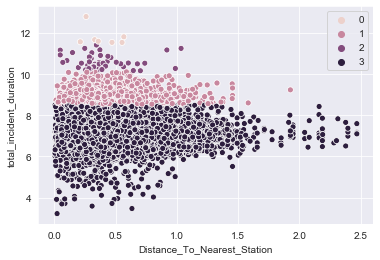

In [235]:
sns.scatterplot(x = X_train['Distance_To_Nearest_Station'], y = np.log(X_train['total_incident_duration']), hue = labels)

In [236]:
X_train2.columns

Index(['response_time', 'LONG', 'LAT', 'PRCP', 'SNOW', 'SNWD',
       'Distance_To_Nearest_Station', 'hour', 'total_incident_duration',
       'units_onscene'],
      dtype='object')

In [237]:
cols_to_keep = ['response_time','LONG', 'LAT', 'PRCP','SNOW','SNWD','Distance_To_Nearest_Station','hour', 'units_onscene']
X_train3 = X_train[cols_to_keep]

In [238]:
kmeans = KMeans(init='random', # initialization
        n_clusters=4,  # number of clusters
        n_init=7,       # number of different times to run k-means
        n_jobs=-1)

kmeans.fit(X_train3)
labels = kmeans.labels_

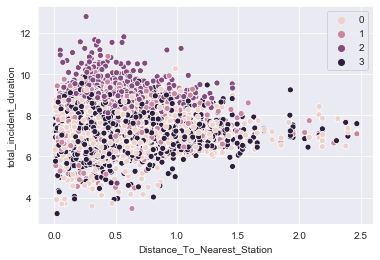

In [239]:
sns.scatterplot(x = X_train['Distance_To_Nearest_Station'], y = np.log(X_train['total_incident_duration']), hue = labels)

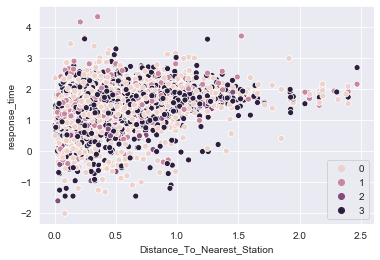

In [240]:
sns.scatterplot(x = X_train['Distance_To_Nearest_Station'], y = np.log(X_train['response_time']), hue = labels)

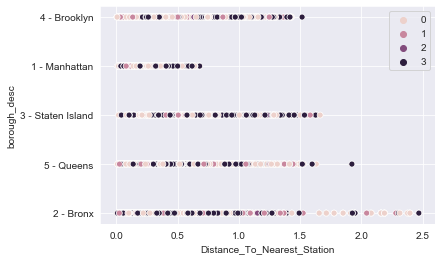

In [241]:
sns.scatterplot(x = X_train['Distance_To_Nearest_Station'], y =(X_train['borough_desc']), hue = labels)

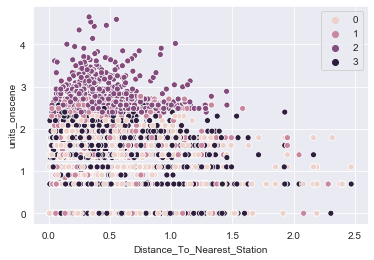

In [242]:
sns.scatterplot(x = X_train['Distance_To_Nearest_Station'], y = np.log(X_train['units_onscene']), hue = labels)

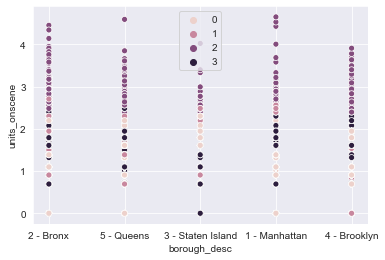

In [243]:
sns.scatterplot(x = X_train['borough_desc'], y = np.log(X_train['units_onscene']), hue = labels)

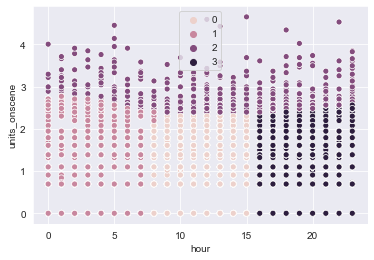

In [244]:
sns.scatterplot(x = X_train['hour'], y = np.log(X_train['units_onscene']), hue = labels)

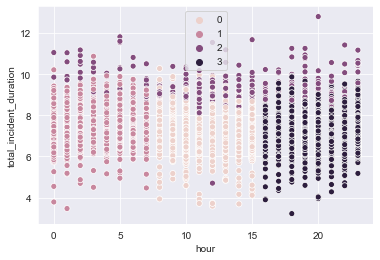

In [245]:
sns.scatterplot(x = X_train['hour'], y = np.log(X_train['total_incident_duration']), hue = labels)

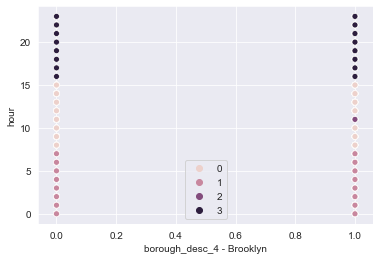

In [246]:

sns.scatterplot(x = y_train, y = (X_train['hour']), hue = labels)

In [247]:
customPalette = sns.set_palette(sns.color_palette("bright"))
eps = 63.85
minpts = 99
db = DBSCAN(eps=eps, min_samples=minpts).fit(X_train2)
labels = db.labels_

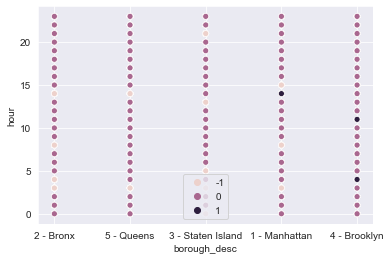

In [248]:
sns.scatterplot(palette = customPalette, x = X_train['borough_desc'], y = (X_train['hour']), hue = labels)

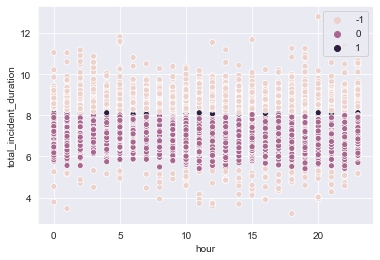

In [249]:
sns.scatterplot(x = X_train['hour'], y = np.log(X_train['total_incident_duration']), hue = labels)

# Association Rule Mining: 

We can leverage the unique incident identifier code as a "transaction" identifier that treats each fire incident as a unique transaction. Doing this, we can hopefully identify association rules of interest related to the types of fires and other aspects of interest. 

We use: https://stackabuse.com/association-rule-mining-via-apriori-algorithm-in-python/ as a reference throughout this analysis. It helps to ensure the methodology to get the data into the right format for Apriori analysis. 

In [250]:
from apyori import apriori

In [268]:

subsample = final_df.sample(frac=0.2, replace=False, random_state=1234)

In [269]:
subsample.shape

(5264, 32)

In [ ]:
#Convert the dataframe into a list of records that Apriori can use

records = []
for i in range(0, 5264):
    records.append([str(subsample.values[i,j]) for j in range(0, 32)])

In [ ]:
association_rules = apriori(records, min_support=0.0045, min_confidence=0.2, min_lift=3, min_length=2, use_colnames=True, verbose=1)
association_results = list(association_rules)

In [ ]:
print(len(association_results))

In [ ]:
print(association_results[0])

In [ ]:
for item in association_results:

    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("Rule: " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(item[1]))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")